In [320]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn
import plotly.express as px

import scipy.stats as sts
import statsmodels.api as sm

In [115]:
df0 = pd.read_csv("data/cookie_cats.csv")

print(df0.dtypes)

df=df0.copy()
df.version = df.version.replace({'gate_30':'A', 'gate_40':'B'})
df = df.rename(columns={'version':'group'})
df.userid = df.userid.astype('string') 

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object


In [116]:
df.isna().sum()

userid            0
group             0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [245]:
df.userid.duplicated().value_counts()

userid
False    90188
Name: count, dtype: int64

In [117]:
df.dtypes

userid            string[python]
group                     object
sum_gamerounds             int64
retention_1                 bool
retention_7                 bool
dtype: object

In [118]:
df.groupby('group').count()

,userid,sum_gamerounds,retention_1,retention_7
group,,,,
A,44700,44700,44700,44700
B,45489,45489,45489,45489


In [119]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [120]:
df['sum_gamerounds'].sort_values(ascending=False).head()

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64

In [121]:
df.iloc[[57702]]

,userid,group,sum_gamerounds,retention_1,retention_7
57702,6390605,A,49854,False,True


In [128]:
df = df[df['userid']!='6390605']

In [129]:
df['sum_gamerounds'].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

In [149]:
#df.query("retention_1==False & retention_7==True")
df.groupby('sum_gamerounds')['userid'].count()

sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

In [217]:
df.groupby('sum_gamerounds')['userid'].count().reset_index()

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
936,2251,1
937,2294,1
938,2438,1
939,2640,1


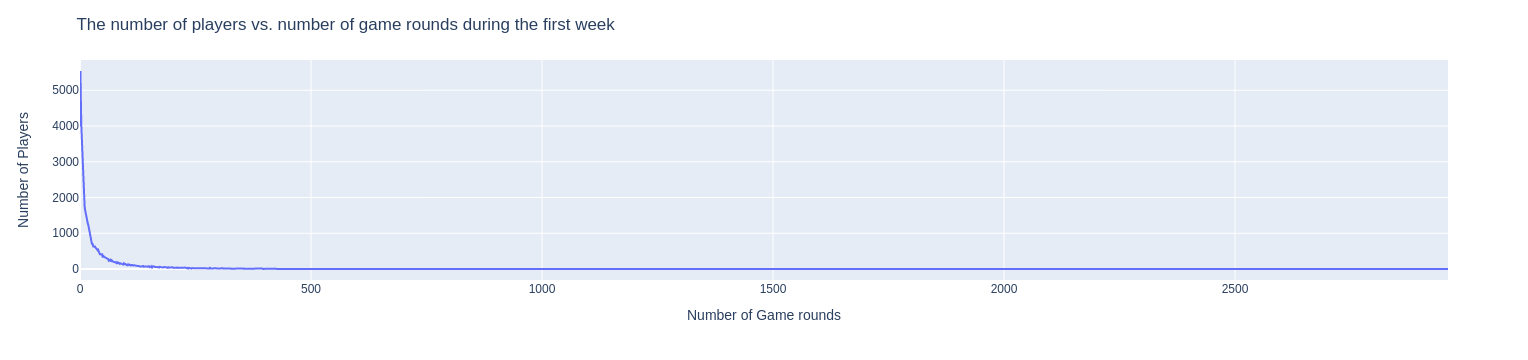

In [224]:
px.line(df.groupby('sum_gamerounds')['userid'].count().reset_index().rename(columns={'sum_gamerounds':'num_rounds', 'userid':'num_users'}),
        x='num_rounds', y='num_users' ).update_layout(
    yaxis_title="Number of Players", xaxis_title="Number of Game rounds", title="The number of players vs. number of game rounds during the first week"
    )



In [239]:
df_distrib = pd.merge(
    df.query("group=='A'").groupby('sum_gamerounds')[['userid']].count().reset_index().rename(columns={'sum_gamerounds':'num_rounds', 'userid':'A'}),
    df.query("group=='B'").groupby('sum_gamerounds')[['userid']].count().reset_index().rename(columns={'sum_gamerounds':'num_rounds', 'userid':'B'}), on='num_rounds' , how='left' )

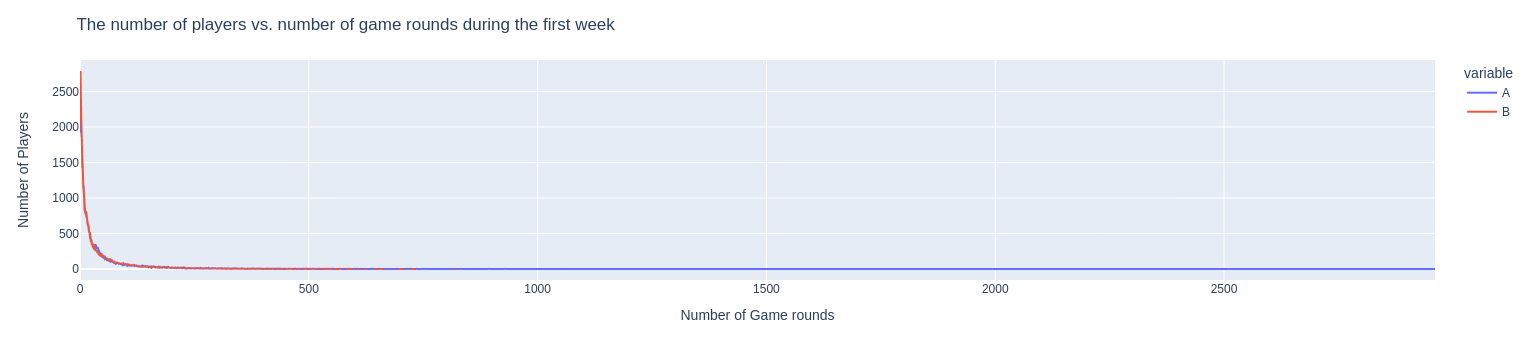

In [240]:
px.line(df_distrib.reset_index(), x='num_rounds', y=['A', 'B']).update_layout(
    yaxis_title="Number of Players", xaxis_title="Number of Game rounds", title="The number of players vs. number of game rounds during the first week"
    )





In [242]:
df.groupby('group')['retention_1'].mean()

group
A    0.448198
B    0.442283
Name: retention_1, dtype: float64

In [312]:
(df.groupby('group')['retention_1'].mean()['A']-df.groupby('group')['retention_1'].mean()['B']) / df.groupby('group')['retention_1'].mean()['B']*100

1.3374242136666668

In [243]:
df.groupby('group')['retention_7'].mean()

group
A    0.190183
B    0.182000
Name: retention_7, dtype: float64

In [313]:
(df.groupby('group')['retention_7'].mean()['A']-df.groupby('group')['retention_7'].mean()['B']) / df.groupby('group')['retention_7'].mean()['B']*100

4.496252545049613

In [252]:
df.groupby('group')['sum_gamerounds'].mean()

group
A    51.342111
B    51.298776
Name: sum_gamerounds, dtype: float64

In [315]:
(df.groupby('group')['sum_gamerounds'].mean()['A']-df.groupby('group')['sum_gamerounds'].mean()['B']) / df.groupby('group')['sum_gamerounds'].mean()['B']*100

0.08447576606208654

<Axes: ylabel='Density'>

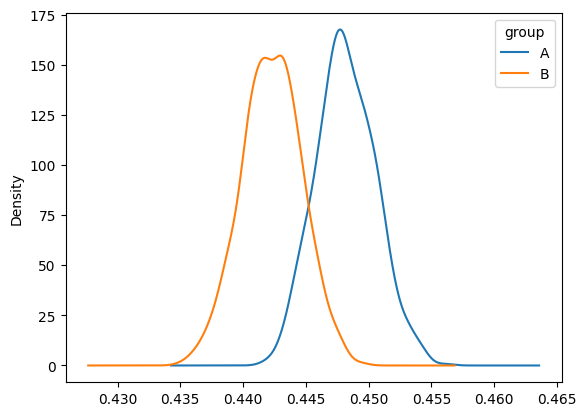

In [256]:
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('group')['retention_1'].mean()
    boot_1d.append(boot_mean)
    

boot_1d = pd.DataFrame(boot_1d)
    

boot_1d.plot(kind='density')

Most likely difference in %: 1.339
Probability that 1-day retention is greater in group A (i.e. when the gate is at level 30): 0.963
Probability that 1-day retention is smaller in group A (i.e. when the gate is at level 30): 0.037


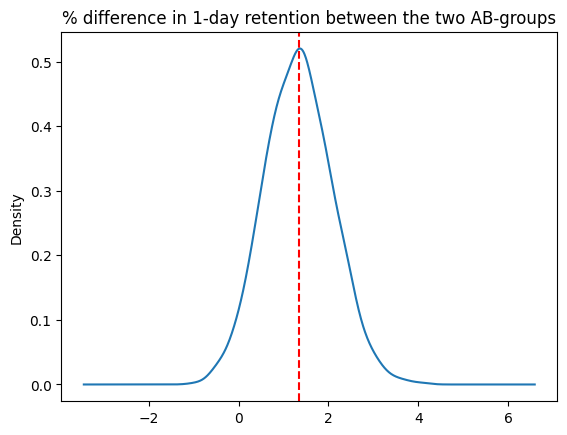

In [294]:
boot_1d['diff'] = (boot_1d['A'] - boot_1d['B'])/boot_1d['B']*100


ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')

plt.axvline(x = boot_1d['diff'].mean(), color = 'red', linestyle='--')

print('Most likely difference in %:', round(boot_1d['diff'].mean(),3))
print('Probability that 1-day retention is greater in group A (i.e. when the gate is at level 30):',(boot_1d['diff'] > 0).mean())
print('Probability that 1-day retention is smaller in group A (i.e. when the gate is at level 30):',(boot_1d['diff'] < 0).mean())

<Axes: ylabel='Density'>

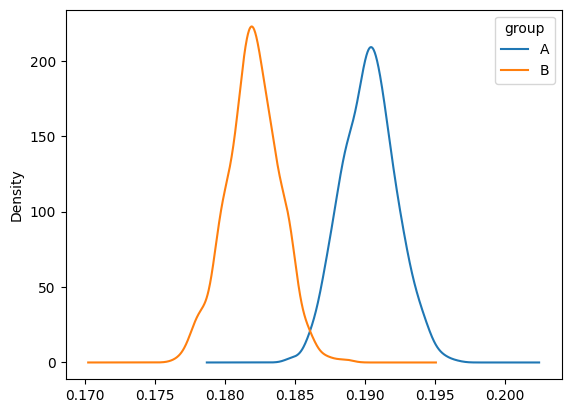

In [300]:
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('group')['retention_7'].mean()
    boot_7d.append(boot_mean)
    

boot_7d = pd.DataFrame(boot_7d)
    

boot_7d.plot(kind='density')

Most likely difference in %: 4.54
Probability that 7-day retention is greater in group A (i.e. when the gate is at level 30): 0.998
Probability that 7-day retention is smaller in group A (i.e. when the gate is at level 30): 0.002


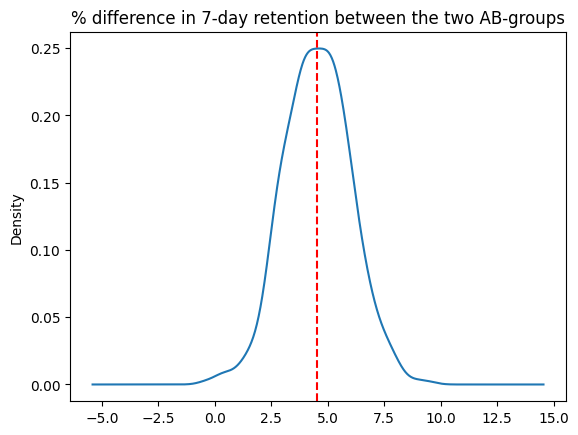

In [302]:
boot_7d['diff'] = (boot_7d['A'] - boot_7d['B'])/boot_7d['B']*100


ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')

plt.axvline(x = boot_7d['diff'].mean(), color = 'red', linestyle='--')

print('Most likely difference in %:', round(boot_7d['diff'].mean(),3))
print('Probability that 7-day retention is greater in group A (i.e. when the gate is at level 30):',(boot_7d['diff'] > 0).mean())
print('Probability that 7-day retention is smaller in group A (i.e. when the gate is at level 30):',(boot_7d['diff'] < 0).mean())

<Axes: ylabel='Density'>

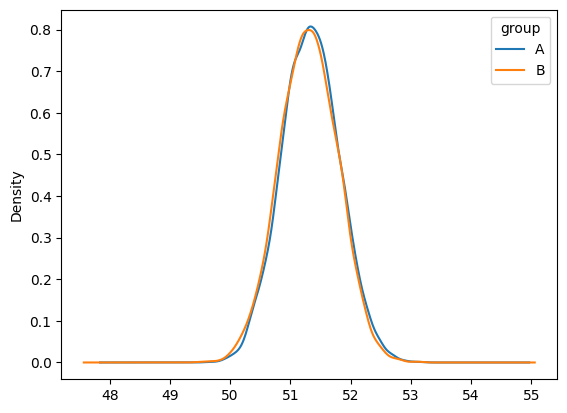

In [298]:
boot_m = []
for i in range(10000):
    boot_mean = df.sample(frac = 1,replace = True).groupby('group')['sum_gamerounds'].mean()
    boot_m.append(boot_mean)
    

boot_m = pd.DataFrame(boot_m)
    

boot_m.plot(kind='density')

Most likely difference in %: 0.083
Probability that mean number of played rounds is greater in group A (i.e. when the gate is at level 30): 0.5197
Probability that mean number of played rounds is smaller in group A (i.e. when the gate is at level 30): 0.4803


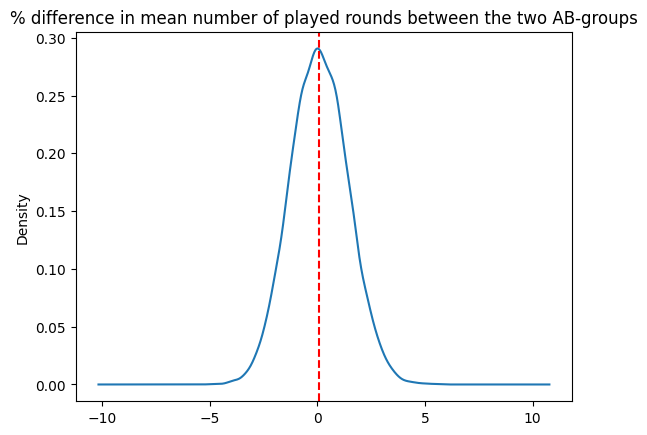

In [301]:
boot_m['diff'] = (boot_m['A'] - boot_m['B'])/boot_m['B']*100


ax = boot_m['diff'].plot(kind='density')
ax.set_title('% difference in mean number of played rounds between the two AB-groups')

plt.axvline(x = boot_m['diff'].mean(), color = 'red', linestyle='--')

print('Most likely difference in %:', round(boot_m['diff'].mean(),3))
print('Probability that mean number of played rounds is greater in group A (i.e. when the gate is at level 30):',(boot_m['diff'] > 0).mean())
print('Probability that mean number of played rounds is smaller in group A (i.e. when the gate is at level 30):',(boot_m['diff'] < 0).mean())

In [318]:
# Are these tiny differences statistically significant?

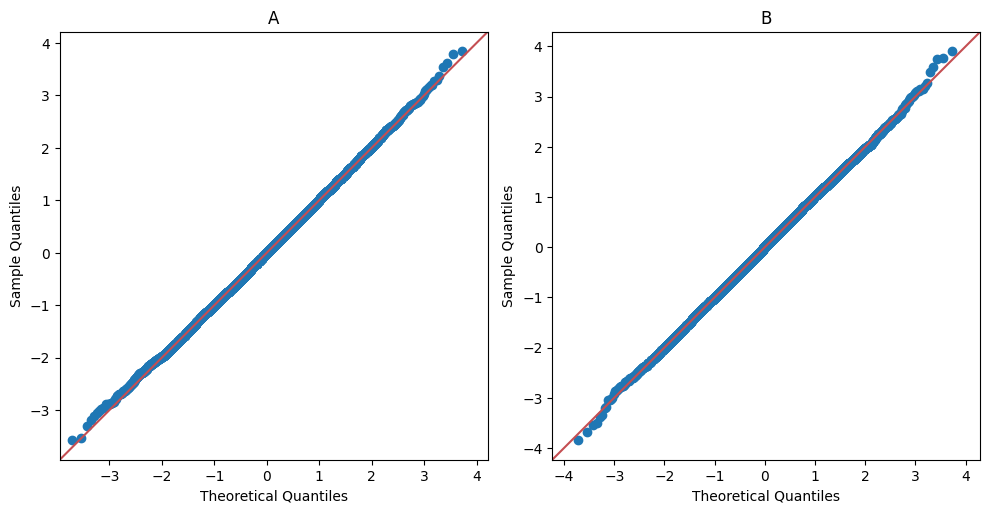

In [327]:
dups_norm_QQfig = plt.figure(2, figsize=(10, 5))

QQA_axis = dups_norm_QQfig.add_subplot(121, aspect=1.0)
QQA_axis.set_title('A')
QQB_axis = dups_norm_QQfig.add_subplot(122, aspect=1.0)
QQB_axis.set_title('B')


sm.qqplot(boot_m['A'], dist=sts.norm, fit=True, line='45', ax=QQA_axis)
sm.qqplot(boot_m['B'], dist=sts.norm, fit=True, line='45', ax=QQB_axis)

lines = dups_norm_QQfig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
dots  = dups_norm_QQfig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')
[l.set_color('#c44e52') for l in lines]
[d.set_color('#4c72b0') for d in dots ]
[d.set_alpha(0.3)       for d in dots ]

plt.tight_layout()

In [328]:
print('REGULARS')
print(sts.normaltest(boot_m['A']))
print('ShapirotestResult: ', sts.shapiro(boot_m['A']))
print(sts.anderson(boot_m['A']), '\n')

print('DUPLICATES')
print(sts.normaltest(boot_m['B']))
print('ShapirotestResult: ', sts.shapiro(boot_m['B']))
print(sts.anderson(boot_m['B']))

REGULARS
NormaltestResult(statistic=6.587894073258028, pvalue=0.03710709689734399)
ShapirotestResult:  ShapiroResult(statistic=0.9996824860572815, pvalue=0.11005624383687973)
AndersonResult(statistic=0.5647296674615063, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=51.33971064419149, scale=0.4808802154112059)
 success: True
 message: '`anderson` successfully fit the distribution to the data.') 

DUPLICATES
NormaltestResult(statistic=1.016082505121413, pvalue=0.6016729507002224)
ShapirotestResult:  ShapiroResult(statistic=0.9998058676719666, pvalue=0.5362520217895508)
AndersonResult(statistic=0.46481571180447645, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=51.30173626297994, scale=0.4834380078724158)
 success: True
 message: '`anderson` successfully fit the distribution to t

/home/karol/.venv/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning:

p-value may not be accurate for N > 5000.



In [ ]:
#Obviously the distributions of the mean number of played rounds are normal

In [331]:
# Equal variance?
print(sts.levene( boot_m['A'], boot_m['B'], center='median'), '\n')

print(sts.fligner(boot_m['A'], boot_m['B'], center='median'))

#yes

LeveneResult(statistic=0.43245929102068414, pvalue=0.5107922414397461) 

FlignerResult(statistic=0.4318142722347961, pvalue=0.5111000527462697)


In [334]:
print(sts.ks_2samp(boot_m['A'], boot_m['B']))
print(sts.mannwhitneyu(boot_m['A'], boot_m['B']))
print(sts.ttest_ind(boot_m['A'], boot_m['B']))

KstestResult(statistic=0.0316, pvalue=9.200976539765021e-05, statistic_location=51.27326255882675, statistic_sign=-1)
MannwhitneyuResult(statistic=52070919.0, pvalue=3.924852680379898e-07)
TtestResult(statistic=5.569084428957225, pvalue=2.593744870019035e-08, df=19998.0)


In [350]:
# According to the p values the statistical tests seem to signify that A and B do not come from the same population. Thus, the tiny difference between A and B of 0.083 % is statistically significant.